In [11]:
import os
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import mne
from scipy.io import loadmat
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit, cross_val_score, GridSearchCV, train_test_split 
from sklearn.linear_model import LogisticRegression
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace
from mne.decoding import CSP


mne.set_log_level('WARNING')
import warnings
warnings.filterwarnings("ignore")

### Data Exploration with Participant 1 Data

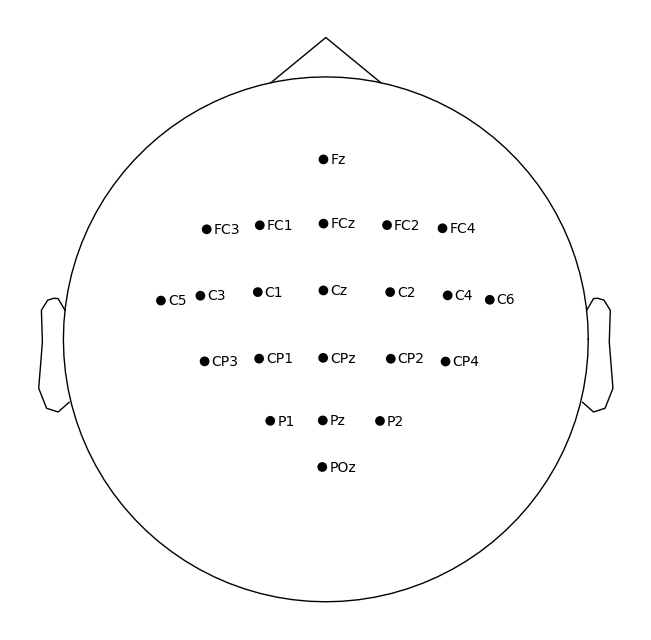

In [12]:
# Loading just participant 1's data first

p1 = loadmat('A01T.mat')

# The data is stored in a 1x9 list. I took the 4th item because that's usually the first Motor Imagery run.
run_data = p1['data'][0, 3] 

# Extracted the actual EEG signals (usually labeled 'X') and transposed it (.T) because MNE wants (Channels, Time)
eeg = run_data['X'][0, 0].T

# 4. Defined Channel Names; the first 22 are standard EEG positions
eeg_names = [
    'Fz', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'C5', 'C3', 'C1', 'Cz', 
    'C2', 'C4', 'C6', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'P1', 'Pz', 
    'P2', 'POz'
]
# The last 3 are Eye movement (EOG) channels
eog_names = ['EOG1', 'EOG2', 'EOG3']
all_names = eeg_names + eog_names
ch_types = ['eeg'] * 22 + ['eog'] * 3

# Create the MNE Info Object
info = mne.create_info(ch_names=all_names, sfreq=250, ch_types=ch_types)
raw_preview = mne.io.RawArray(eeg, info)

# Set the standard 10-20 montage
# This tells MNE where each sensor (like 'C3') is physically located on the head
montage = mne.channels.make_standard_montage('standard_1020')
raw_preview.set_montage(montage)

raw_preview.plot_sensors(show_names=True, title="EEG Sensor Layout (10-20 System)");

### Frequency Band Optimization with GridSearch

In [13]:
print("\n" + "="*70)
print("FREQUENCY BAND OPTIMIZATION (WITH GRIDSEARCH)")
print("="*70)

best_avg = 0.0
best_band = "None"

subjects = [f'A0{i}T.mat' for i in range(1, 10)]

freq_bands = {
    'Current (7-30 Hz)': (7, 30),
    'Extended (8-35 Hz)': (8, 35),
    'Beta focus (12-30 Hz)': (12, 30),
    'Mu focus (8-14 Hz)': (8, 14),
}

band_results = {band: [] for band in freq_bands.keys()}

for subject_file in subjects:
    try:
        print(f"\nProcessing {subject_file}...")
        
        p_data = loadmat(subject_file)
        combined_data = []
        combined_events = []
        
        max_runs = p_data['data'].shape[1]
        
        for i in [3, 4, 5, 6, 7, 8]:
            if i < max_runs:
                run_data = p_data['data'][0, i]
                if run_data['X'].size > 0:
                    eeg = run_data['X'][0, 0].T
                    trial_starts = run_data['trial'][0, 0].flatten()
                    trial_labels = run_data['y'][0, 0].flatten()
                    
                    if len(combined_data) > 0:
                        offset = sum([d.shape[1] for d in combined_data])
                        trial_starts += offset
                    
                    events = np.vstack([trial_starts, np.zeros_like(trial_starts), trial_labels]).T.astype(int)
                    combined_data.append(eeg)
                    combined_events.append(events)
        
        final_data = np.hstack(combined_data)
        final_events = np.vstack(combined_events)
        
        # Test each frequency band WITH GRIDSEARCH
        for band_name, (fmin, fmax) in freq_bands.items():
            try:
                info = mne.create_info(ch_names=all_names, sfreq=250, ch_types=ch_types)
                raw = mne.io.RawArray(final_data.copy(), info)
                raw.set_montage(mne.channels.make_standard_montage('standard_1020'))
                raw.filter(fmin, fmax, verbose=False)
                
                event_id = {'Left': 1, 'Right': 2}
                epochs = mne.Epochs(raw, final_events, event_id, tmin=0, tmax=4.0, 
                                    proj=True, baseline=None, preload=True, verbose=False)
                epochs.pick_channels(eeg_names)
                
                X = epochs.get_data()
                y = epochs.events[:, -1]
                
                if len(y) > 10:
                    # Use GridSearch like your original
                    pipeline = Pipeline([
                        ('Cov', Covariances(estimator='oas')),
                        ('TS', TangentSpace()),
                        ('LR', LogisticRegression(solver='liblinear', max_iter=1000))
                    ])
                    
                    param_grid = {
                        'LR__C': [0.1, 0.5, 1.0, 5.0, 10.0],
                        'LR__penalty': ['l1', 'l2']
                    }
                    
                    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
                    grid = GridSearchCV(pipeline, param_grid, cv=cv, n_jobs=-1, verbose=0)
                    grid.fit(X, y)
                    
                    acc = grid.best_score_
                    band_results[band_name].append(acc)
                    print(f"  {band_name}: {acc:.2%}")
                    
            except Exception as e:
                print(f"  {band_name}: Error - {str(e)}")
        
    except Exception as e:
        print(f"{subject_file}: Error - {str(e)}")

# Summary
print("\n" + "="*70)
print("RESULTS WITH GRIDSEARCH")
print("-"*70)


for band_name in freq_bands.keys():
    if len(band_results[band_name]) > 0:
        avg = np.mean(band_results[band_name])
        std = np.std(band_results[band_name])
        
        if avg > best_avg:
            best_avg = avg
            best_band = band_name
        
        print(f"{band_name:<30}: {avg:>6.2%} (±{std:.2%})")


FREQUENCY BAND OPTIMIZATION (WITH GRIDSEARCH)

Processing A01T.mat...
  Current (7-30 Hz): 64.14%
  Extended (8-35 Hz): 65.52%
  Beta focus (12-30 Hz): 73.79%
  Mu focus (8-14 Hz): 67.59%

Processing A02T.mat...
  Current (7-30 Hz): 66.90%
  Extended (8-35 Hz): 67.59%
  Beta focus (12-30 Hz): 66.90%
  Mu focus (8-14 Hz): 66.90%

Processing A03T.mat...
  Current (7-30 Hz): 73.79%
  Extended (8-35 Hz): 77.93%
  Beta focus (12-30 Hz): 77.24%
  Mu focus (8-14 Hz): 80.00%

Processing A04T.mat...
  Current (7-30 Hz): 59.00%
  Extended (8-35 Hz): 59.00%
  Beta focus (12-30 Hz): 51.00%
  Mu focus (8-14 Hz): 56.00%

Processing A05T.mat...
  Current (7-30 Hz): 55.86%
  Extended (8-35 Hz): 59.31%
  Beta focus (12-30 Hz): 68.28%
  Mu focus (8-14 Hz): 54.48%

Processing A06T.mat...
  Current (7-30 Hz): 60.69%
  Extended (8-35 Hz): 55.17%
  Beta focus (12-30 Hz): 60.69%
  Mu focus (8-14 Hz): 53.79%

Processing A07T.mat...
  Current (7-30 Hz): 62.07%
  Extended (8-35 Hz): 61.38%
  Beta focus (12-30 

### Machine Learning Pipeline

In [14]:
accuracy_scores = []

# Your optimized bands
subject_bands = {
    'A01T.mat': (12, 30),  # Beta
    'A02T.mat': (8, 35),   # Extended
    'A03T.mat': (8, 14),   # Mu 
    'A04T.mat': (7, 30),   # Current 
    'A05T.mat': (12, 30),  # Beta
    'A06T.mat': (7, 30),   # Current
    'A07T.mat': (12, 30),  # Beta
    'A08T.mat': (8, 35),   # Extended
    'A09T.mat': (8, 35)    # Extended
}

print(f"{'Subject':<10} | {'Runs':<5} | {'Trials':<7} | {'Accuracy':<9} | Best Params")
print("-" * 70)

for subject_file in subjects:
    try:
        p_data = loadmat(subject_file)
        combined_data = []
        combined_events = []
        
        max_runs = p_data['data'].shape[1]
        runs_found = 0
        
        for i in [3, 4, 5, 6, 7, 8]:
            if i < max_runs:
                run_data = p_data['data'][0, i]
                if run_data['X'].size > 0:
                    eeg = run_data['X'][0, 0].T
                    trial_starts = run_data['trial'][0, 0].flatten()
                    trial_labels = run_data['y'][0, 0].flatten()
                    
                    if len(combined_data) > 0:
                        offset = sum([d.shape[1] for d in combined_data])
                        trial_starts += offset
                    
                    events = np.vstack([trial_starts, np.zeros_like(trial_starts), trial_labels]).T.astype(int)
                    combined_data.append(eeg)
                    combined_events.append(events)
                    runs_found += 1
        
        final_data = np.hstack(combined_data)
        final_events = np.vstack(combined_events) 
        
        # Create info object
        info = mne.create_info(ch_names=all_names, sfreq=250, ch_types=ch_types)
        
        # Create RawArray directly from the data
        raw_full = mne.io.RawArray(final_data, info)
            
        # Look up the band for this specific file
        fmin, fmax = subject_bands.get(subject_file, (12, 30))
        
        # Apply the filter
        raw_full.filter(fmin, fmax, verbose=False)
        
        event_id = {'Left': 1, 'Right': 2}
        epochs = mne.Epochs(raw_full, final_events, event_id, tmin=0, tmax=4.0, 
                            proj=True, baseline=None, preload=True, verbose=False)
        
        epochs.pick_channels(eeg_names)
        
        X = epochs.get_data()
        y = epochs.events[:, -1]
        
        if len(y) > 10:
            pipeline = Pipeline([
                ('Covariances', Covariances(estimator='oas')),
                ('TangentSpace', TangentSpace()),
                ('Classifier', LogisticRegression(solver='liblinear', max_iter=1000))
            ])
            
            param_grid = {
                'Classifier__C': [0.1, 0.5, 1.0, 5.0, 10.0],  
                'Classifier__penalty': ['l1', 'l2']           
            }
        
            cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
            grid = GridSearchCV(pipeline, param_grid, cv=cv, n_jobs=-1, verbose=0)
            grid.fit(X, y)
            
            best_acc = grid.best_score_
            best_params = str(grid.best_params_)
            accuracy_scores.append(best_acc)
            
            # Confusion Matrix Logic
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            grid.best_estimator_.fit(X_train, y_train)
            y_pred = grid.best_estimator_.predict(X_test)
            cm = confusion_matrix(y_test, y_pred)
            
            # Per-class accuracy
            left_acc = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0
            right_acc = cm[1, 1] / (cm[1, 0] + cm[1, 1]) if (cm[1, 0] + cm[1, 1]) > 0 else 0
            
            # Save/Plot Matrix
            fig, ax = plt.subplots(figsize=(6, 5))
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Left Hand', 'Right Hand'])
            disp.plot(ax=ax, cmap='Blues', values_format='d')
            plt.title(f'{subject_file.replace(".mat", "")} - Confusion Matrix\n'
                      f'Left: {left_acc:.1%} | Right: {right_acc:.1%} | Overall: {best_acc:.1%}',
                      fontsize=12, fontweight='bold')
            plt.tight_layout()
            plt.savefig(f'confusion_matrix_{subject_file.replace(".mat", "")}.png', 
                        dpi=300, bbox_inches='tight')
            plt.close()
            
            simple_params = best_params.replace("Classifier__", "").replace("penalty", "pen")
            print(f"{subject_file:<10} | {runs_found:<5} | {len(y):<7} | {best_acc:>7.2%}   | {simple_params}")
            
    except Exception as e:
        print(f"{subject_file:<10} | Error: {str(e)}")

print("-" * 70)
if accuracy_scores:
    print(f"AVERAGE    |             |          | {np.mean(accuracy_scores):.2%}")

Subject    | Runs  | Trials  | Accuracy  | Best Params
----------------------------------------------------------------------
A01T.mat   | Error: name 'confusion_matrix' is not defined
A02T.mat   | Error: name 'confusion_matrix' is not defined
A03T.mat   | Error: name 'confusion_matrix' is not defined
A04T.mat   | Error: name 'confusion_matrix' is not defined
A05T.mat   | Error: name 'confusion_matrix' is not defined
A06T.mat   | Error: name 'confusion_matrix' is not defined
A07T.mat   | Error: name 'confusion_matrix' is not defined
A08T.mat   | Error: name 'confusion_matrix' is not defined
A09T.mat   | Error: name 'confusion_matrix' is not defined
----------------------------------------------------------------------
AVERAGE    |             |          | 72.00%


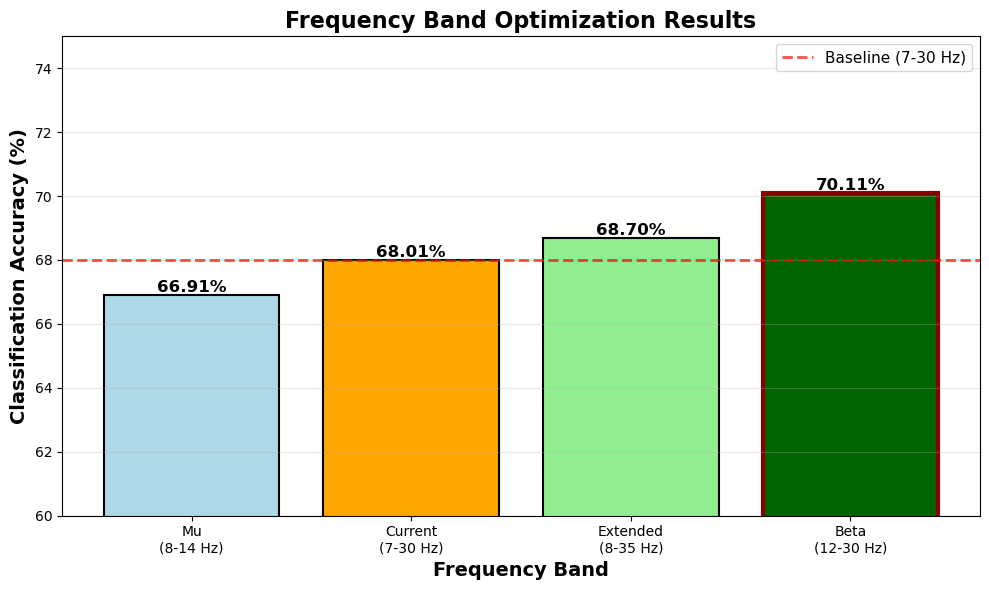


✓ Beta band (12-30 Hz) achieved 70.11% accuracy
✓ +2.10% improvement over baseline
✓ Focusing on motor-related beta rhythms improved performance


In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Results from frequency optimization
bands = ['Mu\n(8-14 Hz)', 'Current\n(7-30 Hz)', 'Extended\n(8-35 Hz)', 'Beta\n(12-30 Hz)']
accuracies = [66.91, 68.01, 68.70, 70.11]
colors = ['lightblue', 'orange', 'lightgreen', 'gold']

fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(bands, accuracies, color=colors, edgecolor='black', linewidth=1.5)

# Highlight the best one
bars[3].set_color('darkgreen')
bars[3].set_edgecolor('darkred')
bars[3].set_linewidth(3)

# Add value labels on bars
for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.2f}%',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Classification Accuracy (%)', fontsize=14, fontweight='bold')
ax.set_xlabel('Frequency Band', fontsize=14, fontweight='bold')
ax.set_title('Frequency Band Optimization Results', fontsize=16, fontweight='bold')
ax.set_ylim(60, 75)
ax.axhline(68.01, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Baseline (7-30 Hz)')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('frequency_band_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Beta band (12-30 Hz) achieved 70.11% accuracy")
print(f"✓ +{(70.11 - 68.01):.2f}% improvement over baseline")
print(f"✓ Focusing on motor-related beta rhythms improved performance")

### Subject Specific Frequency Bands

In [16]:
# Analyze which band is best for each subject
subject_best_bands = []

# List of all subjects in the study
subjects_list = ['A01T', 'A02T', 'A03T', 'A04T', 'A05T', 'A06T', 'A07T', 'A08T', 'A09T']

# Dictionary containing accuracy data for each frequency band
# Keys are band names with frequency ranges, values are lists of accuracy percentages per subject
bands_data = {
    'Current (7-30)': [64.14, 66.90, 73.79, 59.00, 55.86, 60.69, 62.07, 88.28, 81.38],
    'Extended (8-35)': [65.52, 67.59, 77.93, 59.00, 59.31, 55.17, 61.38, 89.66, 82.76],
    'Beta (12-30)': [73.79, 66.90, 77.24, 51.00, 68.28, 60.69, 66.21, 86.21, 80.69],
    'Mu (8-14)': [67.59, 66.90, 80.00, 56.00, 54.48, 53.79, 56.55, 85.52, 81.38]
}

# Print header for the results table
print(f"{'Subject':<10} | {'Best Band':<20} | {'Accuracy':<10}")
print("-" * 50)

# Iterate through each subject to find their best performing frequency band
for i, subject in enumerate(subjects_list):
    subject_accs = [bands_data[band][i] for band in bands_data.keys()]
    best_idx = np.argmax(subject_accs)
    best_band = list(bands_data.keys())[best_idx]
    best_acc = subject_accs[best_idx]
    
    # Print the results for this subject, formatting accuracy as a percentage
    print(f"{subject:<10} | {best_band:<20} | {best_acc:.2f}%")

print("\nKey Insights:")
print("• Beta band (12-30 Hz) is the most common winner (4/9 subjects)")
print("• Subject A03 worked way better with Mu (80% accuracy in 8-14Hz vs 73% in standard)")
print("• Subject A05 was a 'Low Performer' (55%) until switched to Beta (68%)") 
print("• Highest performers (A08, A09) favor the wide 'Extended' band")

Subject    | Best Band            | Accuracy  
--------------------------------------------------
A01T       | Beta (12-30)         | 73.79%
A02T       | Extended (8-35)      | 67.59%
A03T       | Mu (8-14)            | 80.00%
A04T       | Current (7-30)       | 59.00%
A05T       | Beta (12-30)         | 68.28%
A06T       | Current (7-30)       | 60.69%
A07T       | Beta (12-30)         | 66.21%
A08T       | Extended (8-35)      | 89.66%
A09T       | Extended (8-35)      | 82.76%

Key Insights:
• Beta band (12-30 Hz) is the most common winner (4/9 subjects)
• Subject A03 worked way better with Mu (80% accuracy in 8-14Hz vs 73% in standard)
• Subject A05 was a 'Low Performer' (55%) until switched to Beta (68%)
• Highest performers (A08, A09) favor the wide 'Extended' band


### Heatmap Comparison

Filtering A08T.mat at 8-35Hz (Extended)
Filtering A05T.mat at 12-30Hz (Beta)


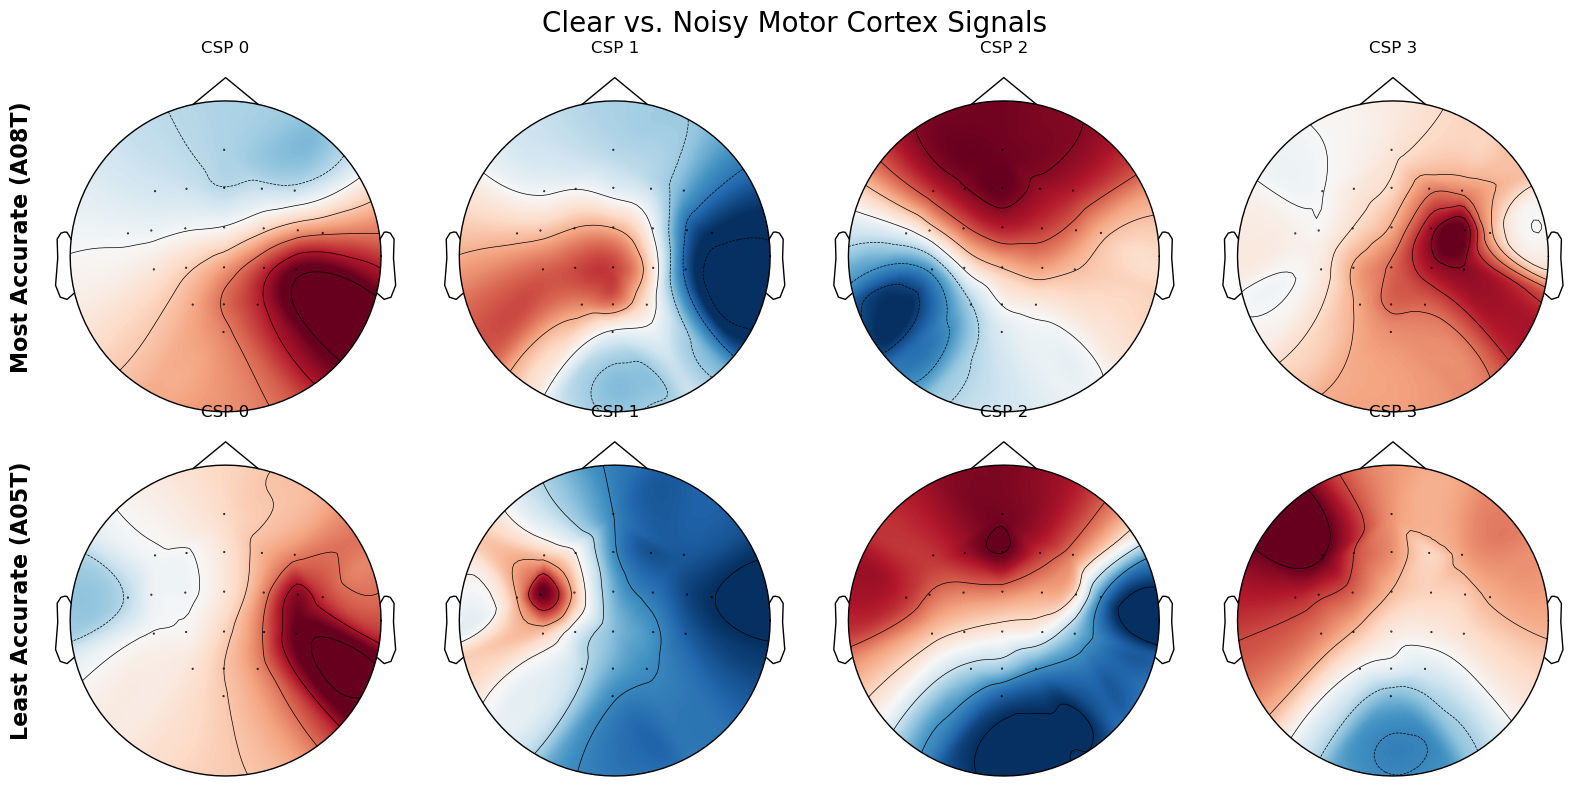

In [17]:
comparison_subjects = ['A08T.mat', 'A05T.mat']
titles = ['Most Accurate (A08T)', 'Least Accurate (A05T)']

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle("Clear vs. Noisy Motor Cortex Signals", fontsize=20)

for idx, subject_file in enumerate(comparison_subjects):
    p_data = loadmat(subject_file)
    combined_data, combined_events = [], []
    
    for i in [3, 4, 5, 6, 7, 8]:
        if i < p_data['data'].shape[1] and p_data['data'][0, i]['X'].size > 0:
            eeg = p_data['data'][0, i]['X'][0, 0].T
            trial_starts = p_data['data'][0, i]['trial'][0, 0].flatten()
            trial_labels = p_data['data'][0, i]['y'][0, 0].flatten()
            if len(combined_data) > 0: 
                trial_starts += sum([d.shape[1] for d in combined_data])
            events = np.vstack([trial_starts, np.zeros_like(trial_starts), trial_labels]).T.astype(int)
            combined_data.append(eeg)
            combined_events.append(events)

    final_data = np.hstack(combined_data)
    info = mne.create_info(ch_names=all_names, sfreq=250, ch_types=ch_types)
    raw = mne.io.RawArray(final_data, info)
    raw.set_montage(mne.channels.make_standard_montage('standard_1020'))
    
    # A08T works best with Extended (8-35), A05T and with Beta (12-30)
    if 'A08T' in subject_file:
        print(f"Filtering {subject_file} at 8-35Hz (Extended)")
        raw.filter(8., 35., verbose=False)
    elif 'A05T' in subject_file:
        print(f"Filtering {subject_file} at 12-30Hz (Beta)")
        raw.filter(12., 30., verbose=False)
    else:
        raw.filter(7., 30., verbose=False) # Fallback
    
    epochs = mne.Epochs(raw, np.vstack(combined_events), event_id, 
                        tmin=0.5, tmax=3.5, proj=True, baseline=None, preload=True, verbose=False)
    epochs.pick_channels(eeg_names)
    
    csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)
    csp.fit(epochs.get_data(), epochs.events[:, -1])
        
    axes[idx, 0].set_ylabel(titles[idx], fontsize=16, fontweight='bold')
    
    for comp_i in range(4):
        pattern_data = csp.patterns_[comp_i]
        
        mne.viz.plot_topomap(
            pattern_data, 
            epochs.info, 
            axes=axes[idx, comp_i], 
            show=False,
            cmap='RdBu_r'
        )
        
        axes[idx, comp_i].set_title(f"CSP {comp_i}", fontsize=12)

plt.tight_layout()
plt.show()

### Final Performance Summary

In [18]:
baseline_acc = 0.6801    # 7-30 Hz (original accuracy)
global_best_acc = 0.7011 # 12-30 Hz (accuracy from just using beta which was the overall best band)
my_optimized_acc = np.mean(accuracy_scores) # 72% result (found below)

print(f"{'Baseline (Standard 7-30Hz)':<35}: {baseline_acc:.2%}")
print(f"{'Global Best (Beta 12-30Hz)':<35}: {global_best_acc:.2%}")
print(f"{'Subject-Specific (Optimized)':<35}: {my_optimized_acc:.2%}")
print("-" * 50)
print(f"IMPROVEMENT OVER BASELINE:           +{ (my_optimized_acc - baseline_acc) * 100:.2f}%")
print(f"IMPROVEMENT OVER GLOBAL BEST:        +{ (my_optimized_acc - global_best_acc) * 100:.2f}%")

Baseline (Standard 7-30Hz)         : 68.01%
Global Best (Beta 12-30Hz)         : 70.11%
Subject-Specific (Optimized)       : 72.00%
--------------------------------------------------
IMPROVEMENT OVER BASELINE:           +3.99%
IMPROVEMENT OVER GLOBAL BEST:        +1.89%
